# Bayesian Neural Networks - regularization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import theano
import pymc3 as pm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
from scipy.stats import mode

import lasagne
from lasagne.nonlinearities import softmax, tanh, rectify, leaky_rectify
import seaborn as sns

from utils import plot_confusion_matrix, print_precision_recall_fscore, plot_prediction_surface

plt.style.use('ggplot')

## Load data

In [2]:
X, Y = datasets.make_moons(n_samples=200, noise=0.2, random_state=0)

In [3]:
X = StandardScaler().fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.75, random_state=0)

In [4]:
feature_columns = np.arange(X.shape[1])
target_column = 'target'
df = pd.DataFrame(np.concatenate([X, np.vstack(Y)], axis=1), columns=np.concatenate([feature_columns, [target_column]]))
df.head()

,0,1,target
0,0.287164,0.388199,0.0
1,1.306415,-1.680581,1.0
2,-0.718878,-0.005701,1.0
3,-1.755822,-1.237113,0.0
4,1.429622,-0.968282,1.0


### Plot

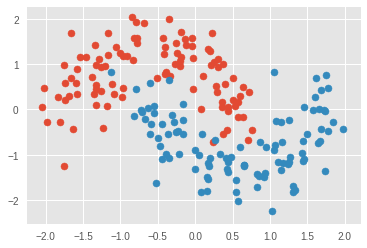

In [5]:
plt.figure(figsize=(6,4))
plt.scatter(X[Y==0][:,0], X[Y==0][:,1])
plt.scatter(X[Y==1][:,0], X[Y==1][:,1])
plt.show();

## Define model

In [6]:
n_hidden = 5

In [7]:
def build_nn_L2_hyper(X_shared, y_shared, n_hidden):

    in_shape = X_shared.get_value().shape
    n_in = in_shape[1]
    n_out = len(np.unique(y_shared.get_value()))

    with pm.Model() as model:

        # regularization hyperparameters
        r_in_1 = pm.HalfNormal('r_in_1', sd=1)
        r_1_2 = pm.HalfNormal('r_1_2', sd=1)
        r_2_out = pm.HalfNormal('r_2_out', sd=1)

        # weights with L2 regularization
        w_in_1 = pm.Normal('w_in_1', 0, sd=r_in_1, shape=(n_in, n_hidden), testval=np.random.randn(n_in, n_hidden))
        w_1_2 = pm.Normal('w_1_2', 0, sd=r_1_2, shape=(n_hidden, n_hidden), testval=np.random.randn(n_hidden, n_hidden))
        w_2_out = pm.Normal('w_2_out', 0, sd=r_2_out, shape=(n_hidden, n_out), testval=np.random.randn(n_hidden, n_out))

        # layers
        l_in = lasagne.layers.InputLayer(in_shape, input_var=X_shared)
        l_1 = lasagne.layers.DenseLayer(l_in, n_hidden, W=w_in_1, nonlinearity=tanh)
        l_2 = lasagne.layers.DenseLayer(l_1, n_hidden, W=w_1_2, nonlinearity=tanh)
        l_out = lasagne.layers.DenseLayer(l_2, n_out, W=w_2_out, nonlinearity=softmax)

        p = pm.Deterministic('p', lasagne.layers.get_output(l_out))
        out = pm.Categorical('out', p=p, observed=y_shared)
        
    return model

## Training

In [8]:
def train(model):
    with model:  
        # pymc3 will automatically assign sampling method (ADVI estimation + NUTS)
        trace_ = pm.sample(1000, n_init=100000, tune=500)
        trace = trace_[500::2]
    return trace

In [9]:
def predict_classes(model, trace):
    # Creater posterior predictive samples
    with model:
        ppc = pm.sample_ppc(trace, samples=100)
    
    # in case we have multiple classes, calculate mode (not mean)
    return mode(ppc['out'], axis=0).mode[0, :]

In [10]:
def train_evaluate(build, n_hidden):
    X_shared = theano.shared(X_train)
    y_shared = theano.shared(Y_train)

    model = build(X_shared, y_shared, n_hidden)
    trace = train(model)

    # in sample validation
    Y_train_pred = predict_classes(model, trace)
    plot_confusion_matrix(Y_train, Y_train_pred)
    print_precision_recall_fscore(Y_train, Y_train_pred)

    # out of sample validation
    X_shared.set_value(X_test)
    y_shared.set_value(Y_test)

    Y_test_pred = predict_classes(model, trace)
    plot_confusion_matrix(Y_test, Y_test_pred)
    print_precision_recall_fscore(Y_test, Y_test_pred)

    plot_prediction_surface(X_shared, y_shared, X_test, model, trace, Y_test_pred, dims=[0,1])
    
    return model, trace, Y_test_pred

## Training model

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 43.638:  10%|█         | 10321/100000 [00:02<00:22, 4035.84it/s]
Convergence archived at 10700
Interrupted at 10,700 [10%]: Average Loss = 68.305
100%|█████████▉| 1499/1500 [01:56<00:00, 16.90it/s]/home/lukasz/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 100/100 [00:00<00:00, 366.53it/s]


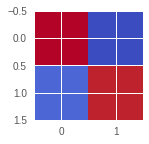

 19%|█▉        | 19/100 [00:00<00:00, 183.21it/s]

Precision: [ 0.91304348  0.96296296] 0.938003220612
Recall: [ 0.95454545  0.92857143] 0.941558441558
F-score: [ 0.93333333  0.94545455] 0.939393939394


100%|██████████| 100/100 [00:00<00:00, 196.28it/s]


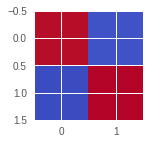

  0%|          | 0/50 [00:00<?, ?it/s]

Precision: [ 0.96103896  0.94520548] 0.953122220246
Recall: [ 0.94871795  0.95833333] 0.953525641026
F-score: [ 0.95483871  0.95172414] 0.953281423804


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


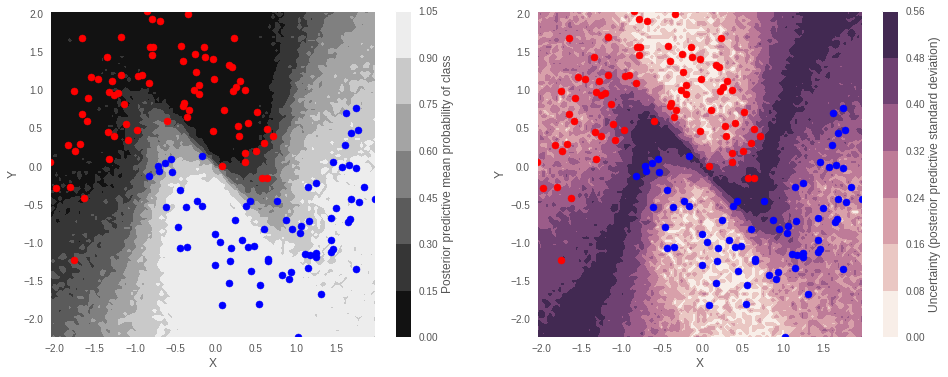

In [11]:
model, trace, pred = train_evaluate(build_nn_L2_hyper, n_hidden)

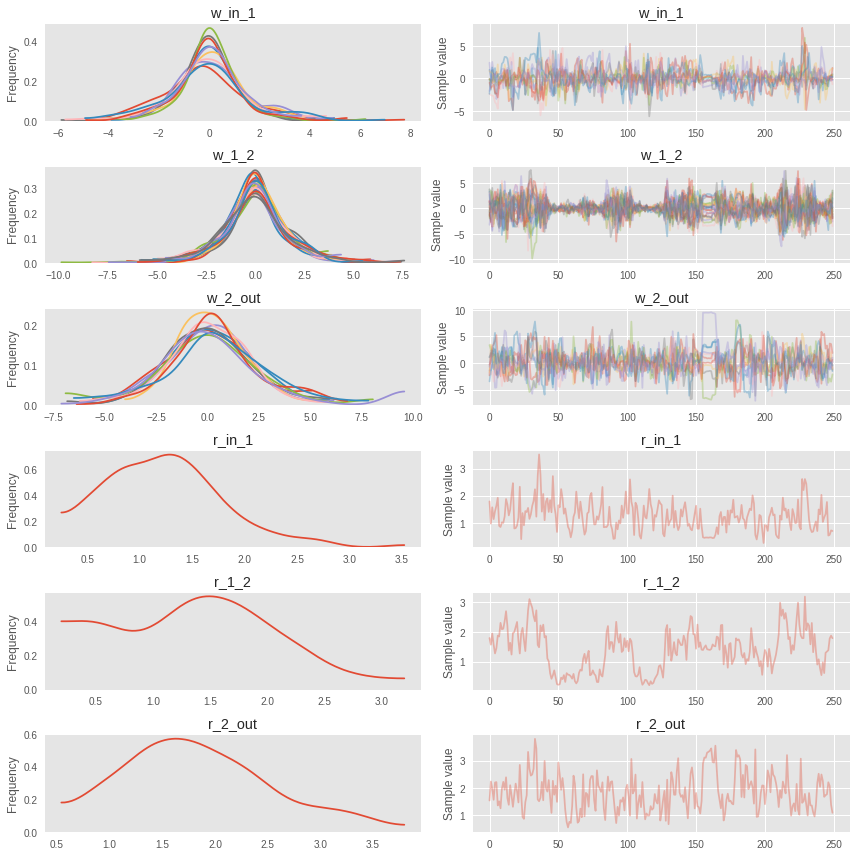

In [12]:
pm.traceplot(trace, varnames=['w_in_1', 'w_1_2', 'w_2_out', 'r_in_1', 'r_1_2', 'r_2_out']);

---

## Compare with Keras

In [13]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout
from keras.optimizers import SGD

m = Sequential()
m.add(Dense(n_hidden, input_dim=X_train.shape[1], activation='tanh', kernel_regularizer='l2'))
m.add(Dense(n_hidden, activation='tanh', kernel_regularizer='l2'))
m.add(Dense(2, kernel_initializer='normal', activation='softmax', kernel_regularizer='l2'))

m.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='sgd')

m.fit(X_train, Y_train, epochs=1000, verbose=False)

Using TensorFlow backend.


32/50 [==================>...........] - ETA: 0s

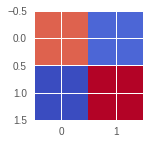

Precision: [ 0.9         0.86666667] 0.883333333333
Recall: [ 0.81818182  0.92857143] 0.873376623377
F-score: [ 0.85714286  0.89655172] 0.87684729064


In [14]:
Y_train_pred = m.predict_classes(X_train)
plot_confusion_matrix(Y_train, Y_train_pred)
print_precision_recall_fscore(Y_train, Y_train_pred)

 32/150 [=====>........................] - ETA: 0s

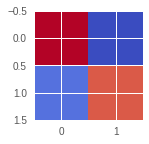

Precision: [ 0.83333333  0.87878788] 0.856060606061
Recall: [ 0.8974359   0.80555556] 0.851495726496
F-score: [ 0.86419753  0.84057971] 0.852388620505


In [15]:
Y_test_pred = m.predict_classes(X_test)
plot_confusion_matrix(Y_test, Y_test_pred)
print_precision_recall_fscore(Y_test, Y_test_pred)

**Observe**

- BNN provides much better prediction accuracy
    - 0.94 (BNN with L2 & hyperparameter)
    - 0.84 (Keras with L2)